In [23]:
import clean_data_svi as cds
import supervised as sup
import pathlib
import keras_model as km
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from datetime import timedelta, datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, LSTM
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, median_absolute_error, roc_curve, auc, f1_score, precision_recall_curve, r2_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix


In [24]:
SVI_list = []
for i in range(4):
    df = pd.read_csv(f"clean_tables/svi_{i+1}.csv", index_col="date")
    df = df.drop(columns=['Settling_velocity', 'SV_label', 'SVI_label'])
    df.index = pd.to_datetime(df.index, dayfirst=True)
    SVI_list.append(df)

In [25]:
temp_df = pd.read_csv("clean_tables/temperatur.csv", index_col="date")
temp_df.index = pd.to_datetime(temp_df.index, dayfirst=True)
sludge_age_df = pd.read_csv("clean_tables/sludge_age_f_m.csv", index_col="date")
sludge_age_df.index = pd.to_datetime(sludge_age_df.index, dayfirst=True)

In [28]:
reactor_list = []
for i in range(4):
    join = pd.concat([SVI_list[i], temp_df], axis=1)
    if i <=1:
        join = pd.concat([join, sludge_age_df.iloc[:, np.r_[0, 2]]], axis=1)
    else:
        join = pd.concat([join, sludge_age_df.iloc[:, np.r_[1, 3]]], axis=1)
    months_df = pd.get_dummies(join.index.year, prefix='year')
    months_df.index=join.index
    join = pd.concat([join, months_df], axis=1)
    reactor_list.append(join)

In [34]:
reactor_list[0]

,SVI,Temperature,F_M - A,Sludge Age - A,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019,year_2020
date,,,,,,,,,,,,,,,
2010-01-01,90.943683,22.030,0.23,3.44,1,0,0,0,0,0,0,0,0,0,0
2010-01-02,84.365325,21.985,0.18,3.78,1,0,0,0,0,0,0,0,0,0,0
2010-01-03,94.541139,21.740,0.21,3.82,1,0,0,0,0,0,0,0,0,0,0
2010-01-04,97.402597,21.815,0.21,3.40,1,0,0,0,0,0,0,0,0,0,0
2010-01-05,107.937685,21.890,0.23,3.70,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,166.666667,22.540,0.25,2.75,0,0,0,0,0,0,0,0,0,0,1
2020-12-28,147.453083,22.535,0.26,2.91,0,0,0,0,0,0,0,0,0,0,1
2020-12-29,154.702970,22.660,0.26,2.82,0,0,0,0,0,0,0,0,0,0,1


In [35]:
X, Y = km.create_join_x_y_arr(reactor_list, n_steps_in=2, binary=True)

In [36]:
X.shape

(16064, 2, 15)

In [37]:
X[0]

array([[90.94368341, 22.03      ,  0.23      ,  3.44      ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [84.36532508, 21.985     ,  0.18      ,  3.78      ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

In [38]:
Y[0]

array([1.])

In [39]:
X_normalize, Y_normalize, scalers = km.normalize(X, Y)
Xtrain, Xtest, ytrain, ytest = train_test_split(X_normalize, Y_normalize, test_size=0.10, random_state=42)
model = Sequential()
model.add(LSTM(units=50, activation='relu', name='first_lstm', recurrent_dropout=0.1, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
model.add(Dense(25, activation='relu'))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=[keras.metrics.BinaryAccuracy(name='binary_accuracy', dtype=None, threshold=0.5)])
model.fit(Xtrain, ytrain, epochs=30, batch_size=10, shuffle=True)


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 222.34it/s]


Epoch 1/30
14457/14457 [==============================] - 3s 180us/step - loss: 0.4776 - binary_accuracy: 0.7233
Epoch 2/30
14457/14457 [==============================] - 2s 156us/step - loss: 0.4058 - binary_accuracy: 0.7837
Epoch 3/30
14457/14457 [==============================] - 2s 154us/step - loss: 0.3961 - binary_accuracy: 0.7953
Epoch 4/30
14457/14457 [==============================] - 2s 156us/step - loss: 0.3910 - binary_accuracy: 0.8016
Epoch 5/30
14457/14457 [==============================] - 2s 158us/step - loss: 0.3865 - binary_accuracy: 0.8054
Epoch 6/30
14457/14457 [==============================] - 2s 161us/step - loss: 0.3858 - binary_accuracy: 0.8084
Epoch 7/30
14457/14457 [==============================] - 2s 158us/step - loss: 0.3848 - binary_accuracy: 0.8103
Epoch 8/30
14457/14457 [==============================] - 2s 159us/step - loss: 0.3824 - binary_accuracy: 0.8119
Epoch 9/30
14457/14457 [==============================] - 2s 151us/step - loss: 0.3826 - binary_

In [40]:
Yhat, Ytest = km.evaluate(model, Xtest, ytest, scalers, binary=True)

In [80]:
threshold = 0.63
y_predict = np.where(Yhat > threshold, 1, 0).astype(int)
y_real = Ytest.astype(int)

In [82]:
classes = ['High_svi', 'Low_svi']

In [83]:
cm = confusion_matrix(y_real, y_predict)

Confusion matrix, without normalization
[[356 151]
 [143 957]]


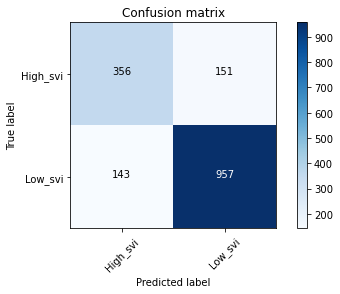

In [84]:
sup.plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [85]:
results = km.results(y_real, y_predict, binary=True)

In [86]:
results

(0.8170504044803982,
 0.7021696252465484,
 0.7134268537074149,
 0.7077534791252486)

In [72]:
fpr, tpr, thresholds = roc_curve(Ytest, Yhat)

In [48]:
auc(fpr, tpr)

0.8803765465303925

Text(0.5, 1.0, 'ROC curve')

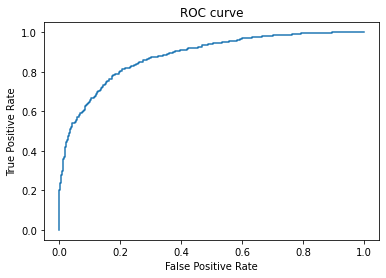

In [49]:
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

In [22]:
results_list = []
for i in range (1,11):
    for j in range (1, 11):
        X, Y = km.create_join_x_y_arr(reactor_list, n_steps_in=i, n_steps_out=j, binary=True)
        X_normalize, Y_normalize, scalers = km.normalize(X, Y)
        Xtrain, Xtest, ytrain, ytest = train_test_split(X_normalize, Y_normalize, test_size=0.20, random_state=42)
        model = Sequential()
        model.add(LSTM(units=50, activation='relu', name='first_lstm', recurrent_dropout=0.1, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
        model.add(Dense(25, activation='relu'))
        model.add(Dense(1, activation="sigmoid"))
        model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy')
        model.fit(Xtrain, ytrain, epochs=30, batch_size=10, shuffle=True)
        Yhat, Ytest = km.evaluate(model, Xtest, ytest, scalers, binary=True)
        y_predict = np.rint(Yhat).astype(int)
        y_real = Ytest.astype(int)
        results_list.append(km.results(y_real, y_predict))
    


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 330.18it/s]


Epoch 1/30
12854/12854 [==============================] - 2s 158us/step - loss: 0.6380
Epoch 2/30
12854/12854 [==============================] - 2s 131us/step - loss: 0.6124
Epoch 3/30
12854/12854 [==============================] - 2s 129us/step - loss: 0.5937
Epoch 4/30
12854/12854 [==============================] - 2s 128us/step - loss: 0.5677
Epoch 5/30
12854/12854 [==============================] - 2s 136us/step - loss: 0.5354
Epoch 6/30
12854/12854 [==============================] - 2s 130us/step - loss: 0.5006
Epoch 7/30
 1950/12854 [===>..........................] - ETA: 1s - loss: 0.4931

KeyboardInterrupt: 

In [ ]:
(unique, counts) = np.unique(ytrain, return_counts=True)
frequencies = np.asarray((unique, counts)).T

In [ ]:
frequencies

In [ ]:
#plot graph of a metric result for all n_step_in and n_step_out values
x=range(1,11)
label = ['accuracy', 'TNR', 'NPV', 'f1']
for z in range(4):
    for i in range(10): # n_step_in=window size
        y=[]
        for j in range (10): # n_step_out = Horizon prediction
            y.append(results_list[i*10:i*10+10][j][z+1])
        plt.plot(x, y, label=f'n_steps_in={i+1}')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel("n_steps_out")
    plt.ylabel(label[z])
    plt.title("Simple LSTM, 3 layers (50,25,1),\n name='first_lstm', recurrent_dropout=0.1 \n optimizer='adam', loss='binary_crossentropy' ")
    plt.savefig(f"figures/Simple LSTM {label[z]}.png", bbox_inches="tight")
    plt.close()

In [ ]:
#plot graph of all metric results for a n_step_in value
x=range(1,11)
label = ['accuracy', 'TNR', 'NPV', 'f1']
for z in range(10):
    for i in range(4):
        y=[]
        for j in range (10):
            y.append(results_list[z*10:z*10+10][j][i+1])
        plt.plot(x, y, label=label[i])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel("n_steps_out")
    plt.ylabel('Metric value')
    plt.title(f"Simple LSTM, 3 layers (50,25,1),\n name='first_lstm', recurrent_dropout=0.1 \n optimizer='adam', loss='binary_crossentropy' \n n_steps_in={z+1} ")
    plt.savefig(f"figures/Simple_LSTM/Simple LSTM n_steps_in={z+1}.png", bbox_inches="tight")
    plt.close()